In [318]:
import numpy as np                   
import pandas as pd                 
import xgboost as xgb                
import shap

import matplotlib.pyplot as plt
pd.options.display.max_columns = 999

%matplotlib inline

np.random.seed(12345)

# Explore and prepare UCI credit card default data

UCI credit card default data: https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients

The UCI credit card default data contains demographic and payment information about credit card customers in Taiwan in the year 2005. The data set contains 23 input variables: 

* **`LIMIT_BAL`**: Amount of given credit (NT dollar)
* **`SEX`**: 1 = male; 2 = female
* **`EDUCATION`**: 1 = graduate school; 2 = university; 3 = high school; 4 = others 
* **`MARRIAGE`**: 1 = married; 2 = single; 3 = others
* **`AGE`**: Age in years 
* **`PAY_0`, `PAY_2` - `PAY_6`**: History of past payment; `PAY_0` = the repayment status in September, 2005; `PAY_2` = the repayment status in August, 2005; ...; `PAY_6` = the repayment status in April, 2005. The measurement scale for the repayment status is: -1 = pay duly; 1 = payment delay for one month; 2 = payment delay for two months; ...; 8 = payment delay for eight months; 9 = payment delay for nine months and above. 
* **`BILL_AMT1` - `BILL_AMT6`**: Amount of bill statement (NT dollar). `BILL_AMNT1` = amount of bill statement in September, 2005; `BILL_AMT2` = amount of bill statement in August, 2005; ...; `BILL_AMT6` = amount of bill statement in April, 2005. 
* **`PAY_AMT1` - `PAY_AMT6`**: Amount of previous payment (NT dollar). `PAY_AMT1` = amount paid in September, 2005; `PAY_AMT2` = amount paid in August, 2005; ...; `PAY_AMT6` = amount paid in April, 2005. 

These 23 input variables are used to predict the target variable, whether or not a customer defaulted on their credit card bill in late 2005. Because XGBoost accepts only numeric inputs, all variables will be treated as numeric.

### Import data and clean
The credit card default data is available as an `.xls` file. Pandas reads `.xls` files automatically, so it's used to load the credit card default data.

In [319]:
#Import XLS file
path = './data/default_of_credit_card_clients.xls'
data = pd.read_excel(path,
                     skiprows=1) # skip the first row of the spreadsheet

### Assign modeling roles

The shorthand name `y` is assigned to the prediction target. `X` is assigned to all other input variables in the credit card default data except the row indentifier, `ID`.

In [320]:
#Assign target and inputs for GBM
y = 'PAY_0'
X = [name for name in data.columns if name not in [y, 'ID','default payment next month']]
print('y =', y)
print('X =', X)

y = PAY_0
X = ['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']


In [321]:
#Convert PAY_0 to be 0-num_classes as XGBoost expects a multinomial outcome to have a min value of 0
for i in range(0, data.shape[0]):
    if data["PAY_0"][i] < 0:
        data["PAY_0"][i] = 0

#Class summary:
#0:'no consumption', 'pay duly', 'use of revolving credit', 
#1:'1 month delay', 
#2:'2 month delay', 
#3:'3 month delay', 
#4:'4 month delay', 
#5:'5 month delay', 
#6:'6 month delay', 
#7:'7 month delay', 
#8:'8 month delay', 9:'9+ month delay'}

### Display descriptive statistics
The Pandas `describe()` function displays a brief description of the credit card default data. The input variables `SEX`, `EDUCATION`, `MARRIAGE`, `PAY_2`-`PAY_6`, and the prediction target `PAY_0`, are really categorical variables, but they have already been encoded into meaningful numeric, integer values, which is great for XGBoost. Also, there are no missing values in this dataset.

In [322]:
data[X + [y]].describe() # display descriptive statistics for all columns

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,PAY_0
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.00000,30000.000000,30000.000000,30000.000000,30000.000000
mean,167484.322667,1.603733,1.853133,1.551867,35.485500,-0.133767,-0.166200,-0.220667,-0.266200,-0.291100,51223.330900,49179.075167,4.701315e+04,43262.948967,40311.400967,38871.760400,5663.580500,5.921163e+03,5225.68150,4826.076867,4799.387633,5215.502567,0.356767
std,129747.661567,0.489129,0.790349,0.521970,9.217904,1.197186,1.196868,1.169139,1.133187,1.149988,73635.860576,71173.768783,6.934939e+04,64332.856134,60797.155770,59554.107537,16563.280354,2.304087e+04,17606.96147,15666.159744,15278.305679,17777.465775,0.760594
min,10000.000000,1.000000,0.000000,0.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-165580.000000,-69777.000000,-1.572640e+05,-170000.000000,-81334.000000,-339603.000000,0.000000,0.000000e+00,0.00000,0.000000,0.000000,0.000000,0.000000
25%,50000.000000,1.000000,1.000000,1.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,3558.750000,2984.750000,2.666250e+03,2326.750000,1763.000000,1256.000000,1000.000000,8.330000e+02,390.00000,296.000000,252.500000,117.750000,0.000000
50%,140000.000000,2.000000,2.000000,2.000000,34.000000,0.000000,0.000000,0.000000,0.000000,0.000000,22381.500000,21200.000000,2.008850e+04,19052.000000,18104.500000,17071.000000,2100.000000,2.009000e+03,1800.00000,1500.000000,1500.000000,1500.000000,0.000000
75%,240000.000000,2.000000,2.000000,2.000000,41.000000,0.000000,0.000000,0.000000,0.000000,0.000000,67091.000000,64006.250000,6.016475e+04,54506.000000,50190.500000,49198.250000,5006.000000,5.000000e+03,4505.00000,4013.250000,4031.500000,4000.000000,0.000000
max,1000000.000000,2.000000,6.000000,3.000000,79.000000,8.000000,8.000000,8.000000,8.000000,8.000000,964511.000000,983931.000000,1.664089e+06,891586.000000,927171.000000,961664.000000,873552.000000,1.684259e+06,896040.00000,621000.000000,426529.000000,528666.000000,8.000000


In [323]:
#Displays last column of Pearson correlation matrix as Pandas DataFrame
pd.DataFrame(data[X + [y]].corr()[y]).iloc[:-1] 

,PAY_0
LIMIT_BAL,-0.170745
SEX,-0.034475
EDUCATION,0.050180
MARRIAGE,-0.011724
AGE,-0.001447
PAY_2,0.524475
PAY_3,0.407515
PAY_4,0.368109
PAY_5,0.339772
PAY_6,0.305063


### Create tuple of monotonicity constraints from Pearson correlation values

The last column of the Pearson correlation matrix is transformed from a numeric column in a Pandas DataFrame into a Python tuple of `1`s and `-1`s that will be used to specifiy monotonicity constraints for each input variable in XGBoost. If the Pearson correlation between an input variable and `PAY_0` is positive and meets our threshold, a positive montonic relationship constraint is specified for that variable using `1`. If the correlation is negative, a negative monotonic constraint is specified using `-1` (if it meets our threshold). Specifying `0` indicates that no constraints should be used, which is set if our threshold is not met. The resulting tuple will be passed to XGBoost when the GBM model is trained.

In [324]:
#Set aside list of monotonic constraints. Fill in as 0 for now, which is unconstrained.
corr = data[X + [y]].corr()[y].values[:-1]
mono_constraints = [0] * corr.shape[0] #Fill in with zeros
mono_constraints

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [325]:
#Fill in mono_constraints list based on Pearon correlation threshold we wish to achieve and
#then convert list to a tuple()
threshold = 0.30
for i in range(0, corr.shape[0]):
    if np.abs(corr[i]) >= threshold:
        mono_constraints[i] = np.sign(corr[i])
mono_constraints = tuple([int(x) for x in mono_constraints])


# creates a tuple in which positive correlation values are assigned a 1# creat 
# and negative correlation values are assigned a -1
mono_constraints_no_threshold = tuple([int(i) for i in np.sign(data[X + [y]].corr()[y].values[:-1])])

# Train Multinomial XGBoost with monotonicity constraints

XGBoost is a very accurate, open source GBM library for regression and classification tasks. XGBoost can learn complex relationships between input variables and a target variable, but here the `monotone_constraints` tuning parameter is used to enforce monotonicity between inputs and the prediction for `PAY_0`. XGBoost's early stopping functionality is also used to limit overfitting to the training data

XGBoost is available from: https://github.com/dmlc/xgboost and the implementation of XGBoost is described in detail here: http://www.kdd.org/kdd2016/papers/files/rfp0697-chenAemb.pdf.

After training, GBM variable importance is calculated and displayed. GBM variable importance is a global measure of the overall impact of an input variable on the GBM model predictions. Global variable importance values give an indication of the magnitude of a variable's contribution to model predictions for all observations. To enhance trust in the GBM model, variable importance values should typically conform to human domain knowledge and reasonable expectations.

### Split data into training and test sets for early stopping

The credit card default data is split into training and test sets to monitor and prevent overtraining. Reproducibility is another important factor in creating trustworthy models, and randomly splitting datasets can introduce randomness in model predictions and other results. A random seed is used here to ensure the data split is reproducible.

In [326]:
np.random.seed(12345) #Set random seed for reproducibility
split_ratio = 0.7     #70%/30% train/test split

#Execute split
split = np.random.rand(len(data)) < split_ratio
train = data[split]
test = data[~split]

#Summarize split
print('Train data rows = %d, columns = %d' % (train.shape[0], train.shape[1]))
print('Test data rows = %d, columns = %d' % (test.shape[0], test.shape[1]))

Train data rows = 20946, columns = 25
Test data rows = 9054, columns = 25


### Train XGBoost GBM multinomial classifier with monotonicity constraints
To train an XGBoost multinomial classifier, the training and test data must be converted from Pandas DataFrames into SVMLight format. The `DMatrix()` function in the XGBoost package is used to convert the data. 

Notice that the monotonicity constraints are passed to XGBoost using the `monotone_constraints` parameter. Because gradient boosting methods typically resample training data, an additional random seed is also specified for XGBoost using the `seed` paramter to create reproducible predictions, error rates, and variable importance values. To avoid overfitting, the `early_stopping_rounds` parameter is used to stop the training process after the test multiclass logloss fails to decrease for 50 iterations.

In [327]:
dtrain = xgb.DMatrix(train[X], train[y])
dtest = xgb.DMatrix(test[X], test[y])

#Used to calibrate predictions to mean of y 
base_y = train[y].mean()

#Tuning parameters
params = {
    'objective': 'multi:softprob',              #Multinomial classification
    'booster': 'gbtree',                        #Base learner will be decision tree
    'eval_metric': 'mlogloss',                  #Stop training based on multinomial logloss
    'eta': 0.08,                                #Learning rate
    'subsample': 0.9,                           #Use 90% of rows in each decision tree
    'colsample_bytree': 0.9,                    #Use 90% of columns in each decision tree
    'max_depth': 10,                            #Allow decision trees to grow to depth of 10
    'monotone_constraints':mono_constraints,    #1 = increasing relationship, -1 = decreasing relationship, 
                                                #0 = unconstrained
    'seed': 12345,                              #Set random seed for reproducibility
    'num_class': 9
}

#Watchlist is used for early stopping
watchlist = [(dtrain, 'train'), (dtest, 'eval')]

#Train model
xgb_model = xgb.train(params,                   #Set tuning parameters from above                   
                      dtrain,                   #Training data
                      1000,                     #Maximum of 1000 iterations (trees)
                      evals=watchlist,          #Use watchlist for early stopping 
                      early_stopping_rounds=50, #Stop after 50 iterations (trees) without decrease in mlogloss
                      verbose_eval=True)        #Display iteration progress


[17:59:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 338 extra nodes, 0 pruned nodes, max_depth=10
[17:59:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 330 extra nodes, 0 pruned nodes, max_depth=10
[17:59:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 334 extra nodes, 0 pruned nodes, max_depth=10
[17:59:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=10
[17:59:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=7
[17:59:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=5
[17:59:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[17:59:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[17:59:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes,

[17:59:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 438 extra nodes, 0 pruned nodes, max_depth=10
[17:59:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 380 extra nodes, 0 pruned nodes, max_depth=10
[17:59:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 348 extra nodes, 0 pruned nodes, max_depth=10
[17:59:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 140 extra nodes, 0 pruned nodes, max_depth=10
[17:59:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=10
[17:59:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=6
[17:59:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[17:59:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[17:59:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes

[15]	train-mlogloss:0.686595	eval-mlogloss:0.750896
[17:59:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 498 extra nodes, 0 pruned nodes, max_depth=10
[17:59:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 398 extra nodes, 0 pruned nodes, max_depth=10
[17:59:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 386 extra nodes, 0 pruned nodes, max_depth=10
[17:59:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 130 extra nodes, 0 pruned nodes, max_depth=10
[17:59:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=9
[17:59:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=9
[17:59:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=4
[17:59:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[17:59:53] src/tree/updater_prune.cc:74: tree 

[23]	train-mlogloss:0.491294	eval-mlogloss:0.571697
[17:59:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 672 extra nodes, 0 pruned nodes, max_depth=10
[17:59:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 374 extra nodes, 0 pruned nodes, max_depth=10
[17:59:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 422 extra nodes, 0 pruned nodes, max_depth=10
[17:59:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 138 extra nodes, 0 pruned nodes, max_depth=10
[17:59:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=10
[17:59:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=6
[17:59:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[17:59:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[17:59:54] src/tree/updater_prune.cc:74: tree

[17:59:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 572 extra nodes, 0 pruned nodes, max_depth=10
[17:59:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 328 extra nodes, 0 pruned nodes, max_depth=10
[17:59:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 364 extra nodes, 0 pruned nodes, max_depth=10
[17:59:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 0 pruned nodes, max_depth=10
[17:59:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=9
[17:59:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=8
[17:59:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=4
[17:59:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[17:59:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, 

[17:59:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 660 extra nodes, 0 pruned nodes, max_depth=10
[17:59:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 316 extra nodes, 0 pruned nodes, max_depth=10
[17:59:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 326 extra nodes, 0 pruned nodes, max_depth=10
[17:59:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 134 extra nodes, 0 pruned nodes, max_depth=10
[17:59:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=10
[17:59:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=6
[17:59:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=4
[17:59:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[17:59:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes

[17:59:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 728 extra nodes, 0 pruned nodes, max_depth=10
[17:59:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 274 extra nodes, 0 pruned nodes, max_depth=10
[17:59:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 172 extra nodes, 0 pruned nodes, max_depth=10
[17:59:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=10
[17:59:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=10
[17:59:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=6
[17:59:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[17:59:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[17:59:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes

[17:59:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 528 extra nodes, 0 pruned nodes, max_depth=10
[17:59:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 348 extra nodes, 0 pruned nodes, max_depth=10
[17:59:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 314 extra nodes, 0 pruned nodes, max_depth=10
[17:59:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=10
[17:59:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=8
[17:59:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=5
[17:59:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[17:59:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[17:59:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, 

[17:59:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 440 extra nodes, 0 pruned nodes, max_depth=10
[17:59:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 264 extra nodes, 0 pruned nodes, max_depth=10
[17:59:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 254 extra nodes, 0 pruned nodes, max_depth=10
[17:59:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 160 extra nodes, 0 pruned nodes, max_depth=10
[17:59:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=10
[17:59:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=8
[17:59:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[17:59:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[17:59:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes

[18:00:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 374 extra nodes, 0 pruned nodes, max_depth=10
[18:00:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 412 extra nodes, 0 pruned nodes, max_depth=10
[18:00:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 238 extra nodes, 0 pruned nodes, max_depth=10
[18:00:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 0 pruned nodes, max_depth=10
[18:00:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=10
[18:00:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=5
[18:00:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[18:00:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[18:00:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes,

[79]	train-mlogloss:0.170875	eval-mlogloss:0.350986
[18:00:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 450 extra nodes, 0 pruned nodes, max_depth=10
[18:00:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 410 extra nodes, 0 pruned nodes, max_depth=10
[18:00:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 242 extra nodes, 0 pruned nodes, max_depth=10
[18:00:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 162 extra nodes, 0 pruned nodes, max_depth=10
[18:00:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=10
[18:00:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=7
[18:00:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[18:00:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[18:00:01] src/tree/updater_prune.cc:74: tree

[18:00:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 338 extra nodes, 0 pruned nodes, max_depth=10
[18:00:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 162 extra nodes, 0 pruned nodes, max_depth=10
[18:00:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 246 extra nodes, 0 pruned nodes, max_depth=10
[18:00:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=10
[18:00:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=10
[18:00:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=8
[18:00:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[18:00:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[18:00:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes

[18:00:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[95]	train-mlogloss:0.146487	eval-mlogloss:0.344978
[18:00:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 256 extra nodes, 0 pruned nodes, max_depth=10
[18:00:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 336 extra nodes, 0 pruned nodes, max_depth=10
[18:00:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 276 extra nodes, 0 pruned nodes, max_depth=10
[18:00:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=10
[18:00:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=9
[18:00:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=6
[18:00:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[18:00:03] src/tree/updater_prune.cc:74: tree 

[18:00:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 316 extra nodes, 0 pruned nodes, max_depth=10
[18:00:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 286 extra nodes, 0 pruned nodes, max_depth=10
[18:00:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 362 extra nodes, 0 pruned nodes, max_depth=10
[18:00:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 150 extra nodes, 0 pruned nodes, max_depth=10
[18:00:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=7
[18:00:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=6
[18:00:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[18:00:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[18:00:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes,

[18:00:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 324 extra nodes, 0 pruned nodes, max_depth=10
[18:00:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 508 extra nodes, 0 pruned nodes, max_depth=10
[18:00:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 186 extra nodes, 0 pruned nodes, max_depth=10
[18:00:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=10
[18:00:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=9
[18:00:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=4
[18:00:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[18:00:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[18:00:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, 

[18:00:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 312 extra nodes, 0 pruned nodes, max_depth=10
[18:00:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 238 extra nodes, 0 pruned nodes, max_depth=10
[18:00:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 268 extra nodes, 0 pruned nodes, max_depth=10
[18:00:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=10
[18:00:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=8
[18:00:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=5
[18:00:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[18:00:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[18:00:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes,

[18:00:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[127]	train-mlogloss:0.113339	eval-mlogloss:0.341938
[18:00:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 380 extra nodes, 0 pruned nodes, max_depth=10
[18:00:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 200 extra nodes, 0 pruned nodes, max_depth=10
[18:00:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 172 extra nodes, 0 pruned nodes, max_depth=10
[18:00:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=10
[18:00:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=10
[18:00:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=5
[18:00:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[18:00:07] src/tree/updater_prune.cc:74: tre

[18:00:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 286 extra nodes, 0 pruned nodes, max_depth=10
[18:00:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 382 extra nodes, 0 pruned nodes, max_depth=10
[18:00:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 324 extra nodes, 0 pruned nodes, max_depth=10
[18:00:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=10
[18:00:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=9
[18:00:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=5
[18:00:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[18:00:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[18:00:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, 

[18:00:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 198 extra nodes, 0 pruned nodes, max_depth=10
[18:00:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 356 extra nodes, 0 pruned nodes, max_depth=10
[18:00:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 282 extra nodes, 0 pruned nodes, max_depth=10
[18:00:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 136 extra nodes, 0 pruned nodes, max_depth=10
[18:00:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=8
[18:00:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=6
[18:00:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[18:00:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[18:00:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes,

[18:00:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 486 extra nodes, 0 pruned nodes, max_depth=10
[18:00:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 234 extra nodes, 0 pruned nodes, max_depth=10
[18:00:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 306 extra nodes, 0 pruned nodes, max_depth=10
[18:00:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 134 extra nodes, 0 pruned nodes, max_depth=10
[18:00:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=9
[18:00:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=5
[18:00:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[18:00:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[18:00:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes,

[18:00:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 302 extra nodes, 0 pruned nodes, max_depth=10
[18:00:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 232 extra nodes, 0 pruned nodes, max_depth=10
[18:00:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 294 extra nodes, 0 pruned nodes, max_depth=10
[18:00:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 146 extra nodes, 0 pruned nodes, max_depth=10
[18:00:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[18:00:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=5
[18:00:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[18:00:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[18:00:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes,

[18:00:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[18:00:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[167]	train-mlogloss:0.087022	eval-mlogloss:0.344562
[18:00:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 230 extra nodes, 0 pruned nodes, max_depth=10
[18:00:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 260 extra nodes, 0 pruned nodes, max_depth=10
[18:00:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 634 extra nodes, 0 pruned nodes, max_depth=10
[18:00:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=10
[18:00:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=7
[18:00:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=4
[18:00:11] src/tree/updater_prune.cc:74: tree

Stopping. Best iteration:
[125]	train-mlogloss:0.114936	eval-mlogloss:0.341644



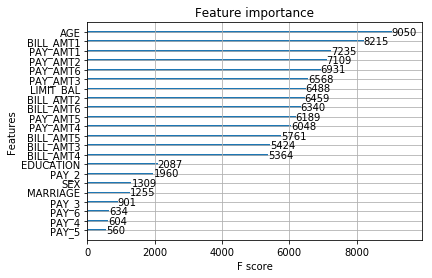

In [328]:
#Variable importance from XGBoost model
xgb.plot_importance(xgb_model)

Text(0.5,0,'relative importance')

<Figure size 432x288 with 0 Axes>

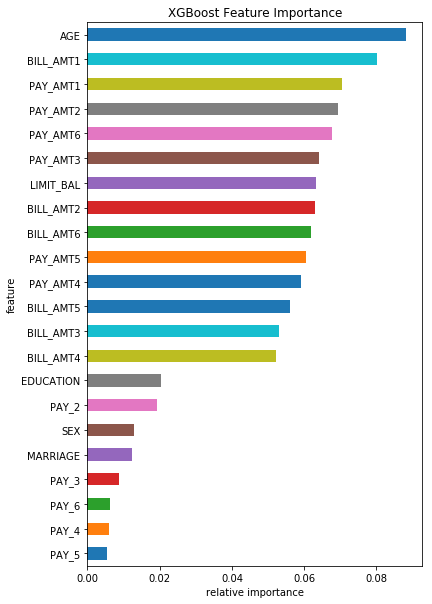

In [329]:
#Another way of looking at variable importance from XGBoost model
import operator
importance = xgb_model.get_fscore()
importance = sorted(importance.items(), key=operator.itemgetter(1))
df = pd.DataFrame(importance, columns=['feature', 'fscore'])
df['fscore'] = df['fscore'] / df['fscore'].sum()

plt.figure()
#df.plot()
df.plot(kind='barh', x='feature', y='fscore', legend=False, figsize=(6, 10))
plt.title('XGBoost Feature Importance')
plt.xlabel('relative importance')

In [330]:
#dtest is DMatrix
#shap_values is Numpy array
shap_values = xgb_model.predict(dtest, pred_contribs=True)

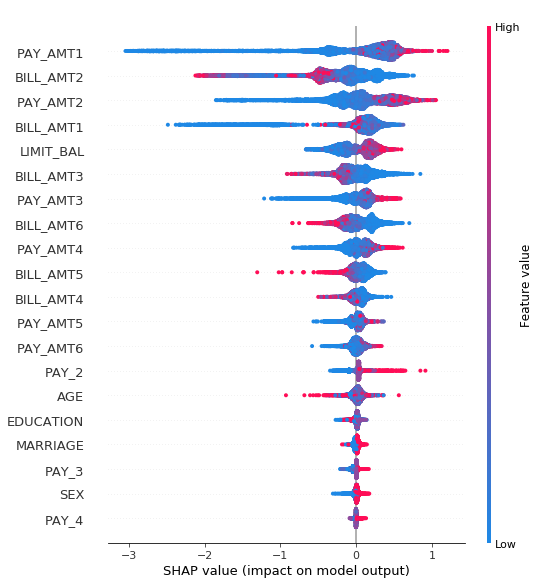

In [331]:
#Plot Shapley variable importance summary for a specific class (class 0, class 1, ..., class 8)
#Class summary:
#0:'no consumption', 'pay duly', 'use of revolving credit', 
#1:'1 month delay', 
#2:'2 month delay', 
#3:'3 month delay', 
#4:'4 month delay', 
#5:'5 month delay', 
#6:'6 month delay', 
#7:'7 month delay', 
#8:'8 month delay', 9:'9+ month delay'}
shap.summary_plot(shap_values[:, 0, :-1], test[xgb_model.feature_names])

In [332]:
#Predict on test set
preds = xgb_model.predict(dtest)

In [333]:
#Each column represents class number: 0, 1, 2, ..., 8. 
preds

array([[2.67e-01, 6.56e-01, 5.40e-02, ..., 8.94e-05, 8.94e-05, 8.94e-05],
       [9.93e-01, 4.34e-04, 6.37e-03, ..., 2.68e-05, 2.68e-05, 2.68e-05],
       [9.89e-01, 1.71e-03, 8.52e-03, ..., 8.89e-05, 8.89e-05, 8.89e-05],
       ...,
       [9.85e-01, 1.38e-02, 1.32e-03, ..., 5.84e-05, 5.84e-05, 5.84e-05],
       [2.15e-02, 3.34e-02, 1.20e-01, ..., 1.02e-04, 1.02e-04, 1.02e-04],
       [9.83e-01, 4.81e-04, 1.63e-02, ..., 2.91e-05, 2.91e-05, 2.91e-05]],
      dtype=float32)

In [334]:
#For each line we need to select that column 
#where the probability is the highest
best_preds = np.asarray([np.argmax(line) for line in preds])
best_preds

array([1, 0, 0, ..., 0, 3, 0])

In [335]:
#Get actual values of PAY_0 in test set
test_true = test["PAY_0"].values

In [336]:
#Look at confusion matrix
from sklearn.metrics import confusion_matrix
cnf_matrix = confusion_matrix(test_true, best_preds)
cnf_matrix

array([[6735,  150,   14,    3,    0,    0,    0,    0,    0],
       [ 151,  874,  146,    2,    0,    2,    0,    1,    1],
       [ 310,  151,  361,    7,    3,    0,    0,    0,    0],
       [   8,   41,   29,   24,    0,    0,    1,    0,    0],
       [   0,   15,    5,    0,    1,    0,    0,    0,    0],
       [   0,    3,    0,    1,    3,    2,    0,    0,    0],
       [   0,    0,    1,    0,    1,    1,    1,    0,    0],
       [   0,    0,    0,    0,    0,    0,    0,    2,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0,    4]])

In [337]:
#Look at precision and F1 with micro and macro averaging
from sklearn.metrics import precision_score, f1_score

print("Macro Precision: %s" % str(precision_score(test_true, best_preds, average='macro')))
print("Micro Precision: %s" % str(precision_score(test_true, best_preds, average='micro')))

print("Macro F1: %s" % str(f1_score(test_true, best_preds, average='macro')))
print("Micro F1: %s" % str(f1_score(test_true, best_preds, average='micro')))

Macro Precision: 0.6036398858236901
Micro Precision: 0.8840291583830351
Macro F1: 0.5466505834335352
Micro F1: 0.8840291583830351
